Topics to cover text classification
1. sentiment analysis
    1.1 Download and explore the IMDB dataset

    1.2 Load the dataset

    1.2 Prepare the dataset for training
    
    1.3 Configure the dataset for
    
    1.4 Create the model

    1.5 Loss function and optimizer

    1.6 Train the model

    1.7 Evaluate the model

    1.8 Create a plot of accuracy and loss over time

2. Export the model

    2.1 Inference on new data

3. Exercise: multi-class classification on Stack Overflow questions
4. Learning more    

In [1]:
import numpy as np
import pandas as pd
import os
import re
import warnings
warnings.filterwarnings(action = 'ignore')
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import losses

In [2]:
print(tf.__version__)

2.15.0


# Sentiment Analysis

This notebook trains a sentiment analysis model to classify movie reviews as positive or negative, based on the text of the review. This is an example of binary—or two-class—classification, an important and widely applicable kind of machine learning problem.

use the Large Movie Review Dataset that contains the text of 50,000 movie reviews from the Internet Movie Database. These are split into 25,000 reviews for training and 25,000 reviews for testing. The training and testing sets are balanced, meaning they contain an equal number of positive and negative reviews.




## Download and explore the IMDB dataset

In [4]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
dataset = tf.keras.utils.get_file("aclImdb_v1", url,
                                  untar=True, cache_dir='.',
                                  cache_subdir = ''
                                  )
dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

84125825/84125825 [==============================] - 21s 0us/step


In [7]:
os.listdir(dataset_dir)

['train', 'imdbEr.txt', 'test', 'README', 'imdb.vocab']

In [10]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['urls_pos.txt',
 'neg',
 'urls_unsup.txt',
 'unsup',
 'unsupBow.feat',
 'labeledBow.feat',
 'urls_neg.txt',
 'pos']

In [13]:
sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
  print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


In [16]:
tf.keras.preprocessing.text_dataset_from_directory(
    dataset_dir,
    labels='inferred',
    label_mode='int',
    class_names=None,
    batch_size=32,
    max_length=None,
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    follow_links=False,

)

Found 100005 files belonging to 2 classes.


<_BatchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [24]:
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

In [23]:
# prompt: NameError: name 'shutil' is not defined

import shutil


### Load the dataset

In [26]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [27]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Review b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label 0
Review b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into 

In [28]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


In [29]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [30]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size)

Found 25000 files belonging to 2 classes.


### Prepare the dataset for training

In [67]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')
text ="""One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fact that it goes where other shows wouldn't dare. Forget pretty pictures painted for mainstream audiences, forget charm, forget romance...OZ doesn't mess around. The first episode I ever saw struck me as so nasty it was surreal, I couldn't say I was ready for it, but as I watched more, I developed a taste for Oz, and got accustomed to the high levels of graphic violence. Not just violence, but injustice (crooked guards who'll be sold out for a nickel, inmates who'll kill on order and get away with it, well mannered, middle class inmates being turned into prison bitches due to their lack of street skills or prison experience) Watching Oz, you may become comfortable with what is uncomfortable viewing....thats if you can get in touch with your darker side."""
print("original text:", text)
print("custom text:")
custom_standardization(text)

original text: One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is

<tf.Tensor: shape=(), dtype=string, numpy=b'one of the other reviewers has mentioned that after watching just 1 oz episode youll be hooked they are right as this is exactly what happened with me  the first thing that struck me about oz was its brutality and unflinching scenes of violence which set in right from the word go trust me this is not a show for the faint hearted or timid this show pulls no punches with regards to drugs sex or violence its is hardcore in the classic use of the word  it is called oz as that is the nickname given to the oswald maximum security state penitentary it focuses mainly on emerald city an experimental section of the prison where all the cells have glass fronts and face inwards so privacy is not high on the agenda em city is home to manyaryans muslims gangstas latinos christians italians irish and moreso scuffles death stares dodgy dealings and shady agreements are never far away  i would say the main appeal of the show is due to the fact that it goes wh

In [68]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [69]:
# Make a text-only dataset (without labels), then call adapt
import string
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [70]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [71]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'"Emma" was a product of what might be called by the First Great Jane Austen Cycle of the mid-nineties, and it was recently shown on British television, doubtless because of the interest in the author created by the Second Great Jane Austen Cycle which started with "Pride and Prejudice" two years ago. We currently have in the cinemas the Austen biopic "Becoming Jane", and ITV have recently produced three TV movies based on Austen novels. These include "Northanger Abbey", the only one of the six major novels not to have been filmed previously, so the cycle should now be complete. No doubt, however, there will be more to come in the near future. (There is, after all, her juvenile "Love and Freindship" (sic), the short novella "Lady Susan", and someone, somewhere, has doubtless supplied endings to her two unfinished fragments "The Watsons" and "Sanditon". Then there are all those Austen sequels churned out by modern writers\xc2\x85\xc2\x85\xc2\x85).<br /><br />The main c

In [74]:
print("1087 ---> ",vectorize_layer.get_vocabulary()[1087])
print(" 413 ---> ",vectorize_layer.get_vocabulary()[413])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1087 --->  revenge
 413 --->  school
Vocabulary size: 10000


In [77]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [78]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b"My children watch the show everyday that its on. Its a great program for younger children. However they need to stop showing re-runs and do some more actual shows and get rid of Rooney's and Deedee's YELLOW TEETH. Moe is the only Doodle bop with clean white pearlie teeth and the children notice these things and ask if the 2 don't ever brush their teeth? Does the show ever make its way to the United States and if so where can we find its schedule at. And one other thing if we might be able to add. Moe you need to stop hiding so much. Sometimes when you pop up out of no where you scare the younger children and whats with the pulling of the rope? What does that signify? other then getting wet all the time. They need to add newer things to their show instead of the same ole same ole. Kids loose interest that way.", shape=(), dtype=string)
Label neg
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[  54,  457,  103,    2,  119, 2813,   12,   29,  

In [75]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

### Configure the dataset for performance

In [76]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model

In [79]:
embedding_dim = 16
model = tf.keras.Sequential([
  layers.Embedding(max_features, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1, activation='sigmoid')])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 16)          160000    
                                                                 
 dropout_2 (Dropout)         (None, None, 16)          0         
                                                                 
 global_average_pooling1d_1  (None, 16)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dropout_3 (Dropout)         (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 160017 (625.07 KB)
Trainable params: 160017 (625.07 KB)
Non-trainable params: 0 (0.00 Byte)
______________

### Loss function and optimizer

In [80]:
model.compile(loss=losses.BinaryCrossentropy(),
              optimizer='adam',
              metrics=[tf.metrics.BinaryAccuracy(threshold=0.5)])

### Train the model

In [81]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
625/625 [==============================] - 38s 59ms/step - loss: 0.6651 - binary_accuracy: 0.6893 - val_loss: 0.6171 - val_binary_accuracy: 0.7748
Epoch 2/10
625/625 [==============================] - 5s 8ms/step - loss: 0.5503 - binary_accuracy: 0.8018 - val_loss: 0.4999 - val_binary_accuracy: 0.8224
Epoch 3/10
625/625 [==============================] - 6s 10ms/step - loss: 0.4454 - binary_accuracy: 0.8443 - val_loss: 0.4211 - val_binary_accuracy: 0.8458
Epoch 4/10
625/625 [==============================] - 3s 4ms/step - loss: 0.3792 - binary_accuracy: 0.8660 - val_loss: 0.3748 - val_binary_accuracy: 0.8596
Epoch 5/10
625/625 [==============================] - 3s 4ms/step - loss: 0.3365 - binary_accuracy: 0.8774 - val_loss: 0.3459 - val_binary_accuracy: 0.8674
Epoch 6/10
625/625 [==============================] - 3s 4ms/step - loss: 0.3067 - binary_accuracy: 0.8881 - val_loss: 0.3267 - val_binary_accuracy: 0.8714
Epoch 7/10
625/625 [==============================] - 4s 6ms/

### Evaluate the model

In [83]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 2s 2ms/step - loss: 0.3101 - binary_accuracy: 0.8736
Loss:  0.3100668489933014
Accuracy:  0.8735600113868713


### Create a plot of accuracy and loss over time

782/782 [==============================] - 2s 2ms/step


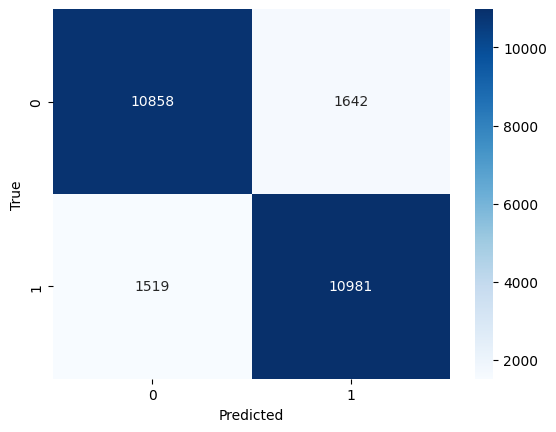

In [88]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Get predictions
y_pred = model.predict(test_ds)

# Convert predictions to binary values
y_pred_binary = [int(round(p[0])) for p in y_pred]

# Get true labels
y_true = []
for images, labels in test_ds:
    y_true.extend(labels.numpy())

# Ensure the number of true labels matches the number of predictions
if len(y_true) != len(y_pred_binary):
    raise ValueError(f"Inconsistent number of samples: y_true ({len(y_true)}) vs y_pred ({len(y_pred_binary)})")

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred_binary)

# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [96]:

from sklearn.metrics import classification_report, confusion_matrix

# Get predictions
y_pred = model.predict(test_ds)

# Convert predictions to binary values
y_pred_binary = [int(round(p[0])) for p in y_pred]

# Get true labels
y_true = []
for images, labels in test_ds:
    y_true.extend(labels.numpy())

# Ensure the number of true labels matches the number of predictions
if len(y_true) != len(y_pred_binary):
    raise ValueError(f"Inconsistent number of samples: y_true ({len(y_true)}) vs y_pred ({len(y_pred_binary)})")

# Create classification report
report = classification_report(y_true, y_pred_binary)
print(report)


782/782 [==============================] - 2s 3ms/step
              precision    recall  f1-score   support

           0       0.88      0.87      0.87     12500
           1       0.87      0.88      0.87     12500

    accuracy                           0.87     25000
   macro avg       0.87      0.87      0.87     25000
weighted avg       0.87      0.87      0.87     25000



In [89]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

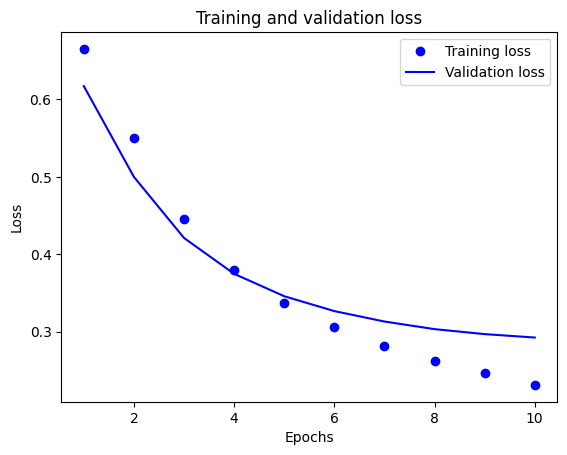

In [90]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

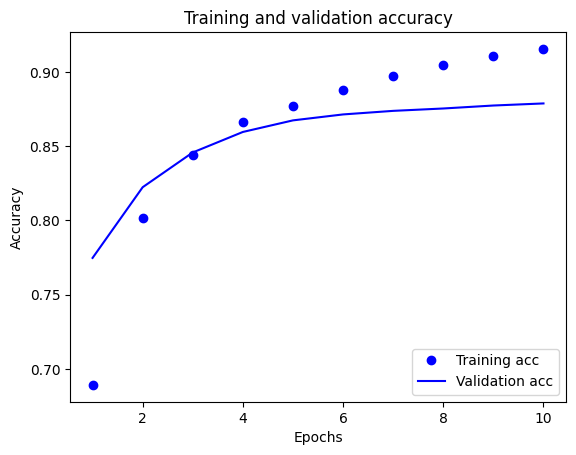

In [91]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

### Export the model

In [92]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

782/782 [==============================] - 4s 5ms/step - loss: 0.5896 - accuracy: 0.5000
0.5


### Inference on new data

In [49]:
examples = tf.constant([
  "The movie was great!",
  "The movie was okay.",
  "The movie was terrible..."
])

export_model.predict(examples)

1/1 [==============================] - 0s 103ms/step


array([[0.65050125],
       [0.60921556],
       [0.58962554]], dtype=float32)

In [93]:

input_text = input("Enter a movie review: ")
predictions = export_model.predict([input_text])
print(
    "This movie review is predicted to be {} with a score of {}.".format(
        "positive" if predictions[0] > 0.6 else "negative", predictions[0]
    )
)


Enter a movie review: import pandas as pd import matplotlib.pyplot as plt import seaborn as sns from sklearn.metrics import confusion_matrix import numpy as np  # Get predictions y_pred = model.predict(test_ds)  # Convert predictions to binary values y_pred_binary = [int(round(p[0])) for p in y_pred]  # Get true labels y_true = [] for images, labels in test_ds:     y_true.extend(labels.numpy())  # Ensure the number of true labels matches the number of predictions if len(y_true) != len(y_pred_binary):     raise ValueError(f"Inconsistent number of samples: y_true ({len(y_true)}) vs y_pred ({len(y_pred_binary)})")  # Create confusion matrix cm = confusion_matrix(y_true, y_pred_binary)  # Plot confusion matrix sns.heatmap(cm, annot=True, fmt="d", cmap="Blues") plt.xlabel("Predicted") plt.ylabel("True") plt.show()
1/1 [==============================] - 0s 153ms/step
This movie review is predicted to be positive with a score of [0.63861454].


In [102]:

model = tf.keras.Sequential([
  layers.Embedding(max_features, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(32, activation='relu'),
  layers.Dense(1, activation='sigmoid')
])

model.compile(loss=losses.BinaryCrossentropy(),
              optimizer='adam',
              metrics=[tf.metrics.BinaryAccuracy(threshold=0.5)])

model.fit(train_ds, epochs=10, validation_data=val_ds)

# 2.2 Try using a different optimizer or loss function:

model.compile(loss=losses.MeanSquaredError(), optimizer='sgd', metrics=[tf.metrics.BinaryAccuracy(threshold=0.5)])

model.fit(train_ds, epochs=10, validation_data=val_ds)

# 2.3 Collect more data to train the model on:

# You can collect more data by scraping movie review websites or using a public dataset like the Rotten Tomatoes dataset.
# Once you have collected more data, you can retrain the model on the larger dataset.


Epoch 1/10
625/625 [==============================] - 34s 52ms/step - loss: 0.5485 - binary_accuracy: 0.7452 - val_loss: 0.3602 - val_binary_accuracy: 0.8574
Epoch 2/10
625/625 [==============================] - 3s 4ms/step - loss: 0.2992 - binary_accuracy: 0.8821 - val_loss: 0.2991 - val_binary_accuracy: 0.8750
Epoch 3/10
625/625 [==============================] - 3s 4ms/step - loss: 0.2338 - binary_accuracy: 0.9100 - val_loss: 0.2925 - val_binary_accuracy: 0.8788
Epoch 4/10
625/625 [==============================] - 4s 7ms/step - loss: 0.1951 - binary_accuracy: 0.9281 - val_loss: 0.2980 - val_binary_accuracy: 0.8786
Epoch 5/10
625/625 [==============================] - 3s 4ms/step - loss: 0.1674 - binary_accuracy: 0.9406 - val_loss: 0.3120 - val_binary_accuracy: 0.8776
Epoch 6/10
625/625 [==============================] - 3s 4ms/step - loss: 0.1424 - binary_accuracy: 0.9510 - val_loss: 0.3323 - val_binary_accuracy: 0.8784
Epoch 7/10
625/625 [==============================] - 4s 6ms/s

In [103]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 2s 2ms/step - loss: 0.1293 - binary_accuracy: 0.8432
Loss:  0.12927788496017456
Accuracy:  0.8431599736213684


In [107]:
# Save the model
model.save('/content/drive/MyDrive/tensorflow_dpl/sentiment_analysis_model')

In [106]:

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive
